In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    datasets,
    callbacks,
    losses,
    optimizers,
    metrics,
)

# from tensorflow.python.framework.ops import disable_eager_execution

# disable_eager_execution()

2024-09-10 22:06:23.111951: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-10 22:06:23.126150: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-10 22:06:23.126193: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-10 22:06:23.136265: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-10 22:06:23.801395: W tensorflow/compiler/tf

In [2]:
def sample_batch(dataset):
    batch = dataset.take(1).get_single_element()
    if isinstance(batch, tuple):
        batch = batch[0]
    return batch.numpy()


def display(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Displays n random images from each one of the supplied arrays.
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()

# Data Preparation

For this implementation, we’ll be using the Fashion-MNIST dataset - a collection of grayscale images of clothing items, each of size 28x28 pixels. (show img from internet)

In [3]:

(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()


These images are originally 28 x 28 in grayscale with pixel values ranging from 0 to 255. To make them suitable for our network, we'll preprocess them by scaling the pixel values to be between 0 and 1. Additionally, we'll pad the images to a size of 32 x 32 to simplify how we work with the data as it goes through the network.

## Data Preprocessing

In [4]:
def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs


x_train = preprocess(x_train)
x_test = preprocess(x_test)

In [5]:
# display(x_train)

# Designing and Building Variational Autoencoder

First, we need to create a new Sampling layer for sampling from the distribution defined by z_mean and z_log_var.

In [6]:
#Sampling Layer

class Sampling(layers.Layer):
    #We create a new layer by subclassing the keras base Layer
    def call(self, inputs):
        #
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [7]:
# Encoder

image_size = 32
embed_dim = 2
encoder_input = layers.Input(
    shape=(image_size, image_size, 1), name="encoder_input"
)
x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(
    encoder_input
)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)
shape_before_flattening = K.int_shape(x)[1:]  # the decoder will need this!

x = layers.Flatten()(x)

#Instead of connecting the Flatten layer directly to the 2D latent space,
#we will connect it to layers z_mean and z_log_var.
z_mean = layers.Dense(embed_dim, name="z_mean")(x)
z_log_var = layers.Dense(embed_dim, name="z_log_var")(x)

#The Sampling layer samples a point z in the latent space from the
#normal distribution defined by the parameters z_mean and z_log_var.
z = Sampling()([z_mean, z_log_var])

#The Keras Model that defines the encoder—a model that takes an input
#image and outputs z_mean, z_log_var and a sampled point z from the
#normal distribution defined by these parameters.
encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

2024-09-03 13:31:53.062510: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-03 13:31:53.088469: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-03 13:31:53.088547: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-03 13:31:53.091875: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-03 13:31:53.091971: I external/local_xla/xla/stream_executor

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 16, 16,    │        320 │ encoder_input[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 8, 8, 64)  │     18,496 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 4, 4, 128) │     73,856 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2048)      │          0 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │      4,098 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │      4,098 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 100,868 (394.02 KB)

 Trainable params: 100,868 (394.02 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Decoder
decoder_input = layers.Input(shape=(embed_dim,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    64, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    32, (3, 3), strides=2, activation="relu", padding="same"
)(x)
decoder_output = layers.Conv2D(
    1,
    (3, 3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output",
)(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Conv2D)         │ (None, 32, 32, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 246,273 (962.00 KB)

 Trainable params: 246,273 (962.00 KB)

 Non-trainable params: 0 (0.00 B)

# Lets Train our Variational Autoencoder

In [9]:
#To create the VAE model, we extend the Keras Model class, enabling us to incorporate the KL
# divergence calculation
#into a custom train_step method.

In [10]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """Call the model on a particular input."""
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """Step run during training."""
        with tf.GradientTape() as tape:
            #TensorFlow's Gradient Tape helps calculate gradients during a forward pass.
            #To use it, we need wrap the code that performs the operations you want to differentiate within a tf.GradientTape() context.
            #After recording the operations, we can compute the gradient of the loss function concerning certain variables using tape.gradient().
            #These gradients are then used to update the variables with the optimizer.

            z_mean, z_log_var, reconstruction = self(data)
            beta = 500
            reconstruction_loss = tf.reduce_mean(
                beta
                * losses.binary_crossentropy(
                    data, reconstruction, axis=(1, 2, 3)
                )
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        beta = 500
        reconstruction_loss = tf.reduce_mean(
            beta
            * losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3))
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [11]:
vae = VAE(encoder, decoder)

# Starting Training

In [12]:
# Compile the variational autoencoder
optimizer = optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer)

In [29]:
vae.fit(
    x_train,
    epochs=10,
    shuffle=True,
    validation_data=(x_test, x_test),
)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - kl_loss: 5.5924 - reconstruction_loss: 123.3561 - total_loss: 128.9485 - val_kl_loss: 5.5649 - val_loss: 123.8313 - val_reconstruction_loss: 118.2663
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - kl_loss: 5.6097 - reconstruction_loss: 123.0152 - total_loss: 128.6251 - val_kl_loss: 5.5670 - val_loss: 122.2718 - val_reconstruction_loss: 116.7047
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - kl_loss: 5.6061 - reconstruction_loss: 123.1388 - total_loss: 128.7449 - val_kl_loss: 5.6789 - val_loss: 123.8155 - val_reconstruction_loss: 118.1366
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - kl_loss: 5.6394 - reconstruction_loss: 123.1532 - total_loss: 128.7926 - val_kl_loss: 5.5492 - val_loss: 123.2471 - val_reconstruction_loss: 117.6979
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - kl_loss: 5.6485 - reconstruction_loss: 122.7481 - total_loss: 128.3965 - val_kl_loss: 5.7045 - val_loss: 123.4636 -

## Saving Trained Checkpoints

# Lets try to reconstruct using our trained variational autoencoder

In [35]:
n_to_predict = 5000

example_images = x_test[n_to_predict:2*n_to_predict:]
example_labels = y_test[n_to_predict:2*n_to_predict:]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Example real clothing items


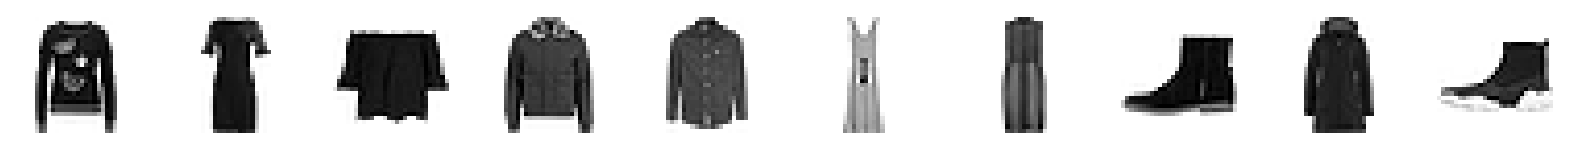

Reconstructions


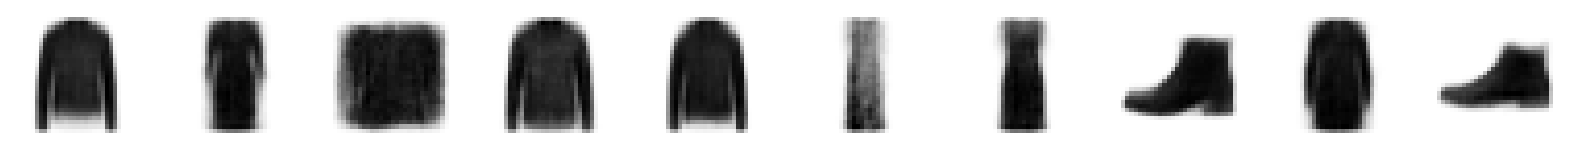

In [36]:
# Create autoencoder predictions and display
z_mean, z_log_var, reconstructions = vae.predict(example_images)
print("Example real clothing items")
display(example_images)
print("Reconstructions")
display(reconstructions)

# Lets visualize Latent Space

In [33]:
z_mean, z_var, z = encoder.predict(example_images)
p = norm.cdf(z)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


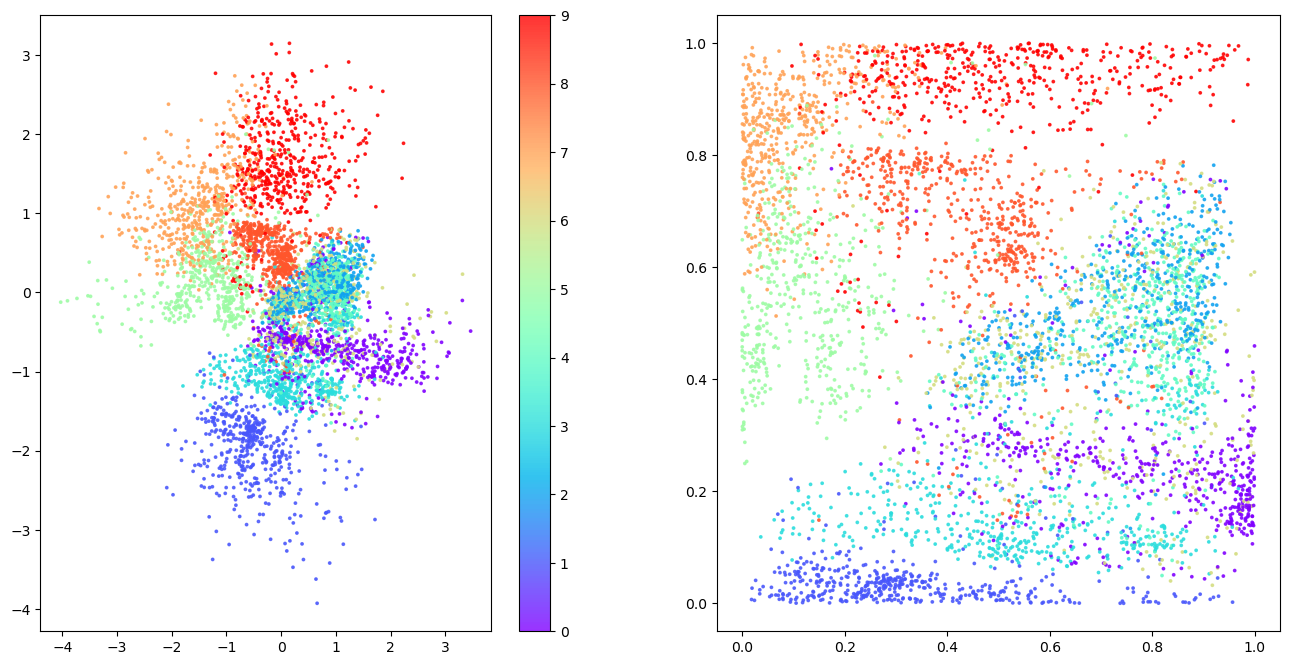

In [34]:



figsize = 8
fig = plt.figure(figsize=(figsize * 2, figsize))
ax = fig.add_subplot(1, 2, 1)
plot_1 = ax.scatter(
    z[:, 0], z[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.colorbar(plot_1)
ax = fig.add_subplot(1, 2, 2)
plot_2 = ax.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.show()

Firstly, the KL divergence loss term keeps z_mean and z_log_var values close to a standard normal distribution. Secondly, the stochastic encoder leads to a more continuous latent space, reducing the occurrence of poorly formed images.


Finally, when we color-code points in the latent space by clothing type, we observe that there is no bias favoring any specific type. The right-hand plot displays the space converted into p-values, revealing nearly equal representation for each color. It's crucial to emphasize that the model learned clothing distinctions independently, without using labels during training, to minimize reconstruction loss.